In [1]:
import keras
from keras.datasets import mnist
import numpy as np
from sklearn import metrics
import h5py
from matplotlib import pyplot as plt 
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
from skimage import io

def show(img):
    io.imshow(img)
    io.show()
def softmax_c(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis]
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] 
    return e_x / div

Using TensorFlow backend.


### Model Compression/Reduction Techniques Studied

#### Logit Regression : NIPS '14
- Formulation: (Regression)
- Loss Function : 
- https://arxiv.org/pdf/1312.6184.pdf
- Do Deep Nets Really Need to be Deep?

#### Song Hans et al. 
- Deep Compression, Pruning, trained-Quantization and Huffman Coding
- Learning both Weights and Connections for Efficient Neural Networks
- Formulation: 
- Loss Function : 

#### Quanitzation of Dense Layer. 
- Discretize the continuous Range of Values in a dense Layer to Clusters
- Little or no Loss of accuracy. 
- Dense Layers are reduced.
- a series of information theoretical vector quantization methods (Jegou et al., 2011; Chen et al., 2010) for compressing dense connected layers. 
- SqueezeNet (Implementation Available)


- They Found simply applying kmeans-based scalar quantization achieves very impressive results. Than Matrix Factorization 
- Compression Rate to Accuracy Tradeoff using Kmeans saclar quantization := 32 / log2 (k)
- Product Quantization .. breaking matrix into S submatrices... and kmeans clustering on each one of them . Compression Rate (32mn)/(32kn + log2(k)ms).


- COMPRESSING DEEP CONVOLUTIONAL NETWORKS
- USING VECTOR QUANTIZATION Yunchao Gong, Liu Liu ∗ , Ming Yang, Lubomir Bourdev

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D , Activation
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 15

# input image dimensions
img_rows, img_cols = 28, 28
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_dim_ordering() == 'th':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32,3,3, activation='relu', input_shape=input_shape))
model.add(Conv2D(64,3,3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

('x_train shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


#### Train cumberSome Model 

In [3]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 26, 26, 32)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 24, 24, 64)    18496       convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 12, 12, 64)    0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 12, 12, 64)    0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

###  Load pre-trained wieghts and Evaluate Model

In [4]:
model.load_weights('stockweighs.h5')
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.028270393712621807)
('Test accuracy:', 0.99139999999999995)


### Parameter Size of Initial Model and Memory Footprint 
- How many parameters does your initial model contain? 
- What is the memory footprint? 
- What is the accuracy on the testing data set?

In [5]:
convparams = 320 + 18496
trainable_params = model.count_params()
footprint = trainable_params * 4

print ("Memory footprint per Image Feed Forward ~= " , footprint / 1024.0 /1024.0 ,"Mb") # 2x Backprop


('Memory footprint per Image Feed Forward ~= ', 4.5771865844726562, 'Mb')


### Distillation of Knowledge in Final Dense Layers , Through Logit Regression 

### Todo:

- See if Redundant Conv-Layers Connections from TL,TR,BL,BR should be pruned. 
- see indices from karpathy slides and learn pruning connections 

### Intermediate Outputs

In [6]:
from keras import backend as K

def prepare_softtargets(model,X):
    inp = model.input                                           # input placeholder
    outputs = []
    for layer in model.layers[:]:
        if layer.name == 'flatten_1':
            outputs.append(layer.output)
        if layer.name == 'dense_2':
            outputs.append(layer.output)
            
    functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function
    layer_outs = functor([X, 1.])
    return np.array(layer_outs[0]) , np.array(layer_outs[1])

### Prepare Train Data for small model 

In [7]:
lastconv_out = []
logit_out = []
for i in range(0,60):
    print "Batch # : ",i
    l,l2 =  ( prepare_softtargets(model,x_train[i*1000:(i+1)*1000]))
    lastconv_out.append(l)
    logit_out.append(l2)
    #lastconv_out , logit_out = prepare_softtargets(model,x_train[i*1000:(i+1)*1000])

# lastconv_out.shape , logit_out.shape
lastconv_out = np.array(lastconv_out)
logit_out = np.array(logit_out)
lastconv_out = lastconv_out.reshape((60000 , 9216))
logit_out = logit_out.reshape((60000 , 10))
print lastconv_out.shape
print logit_out.shape

print "clean up " 
x_train = 0 

Batch # :  0
Batch # :  1
Batch # :  2
Batch # :  3
Batch # :  4
Batch # :  5
Batch # :  6
Batch # :  7
Batch # :  8
Batch # :  9
Batch # :  10
Batch # :  11
Batch # :  12
Batch # :  13
Batch # :  14
Batch # :  15
Batch # :  16
Batch # :  17
Batch # :  18
Batch # :  19
Batch # :  20
Batch # :  21
Batch # :  22
Batch # :  23
Batch # :  24
Batch # :  25
Batch # :  26
Batch # :  27
Batch # :  28
Batch # :  29
Batch # :  30
Batch # :  31
Batch # :  32
Batch # :  33
Batch # :  34
Batch # :  35
Batch # :  36
Batch # :  37
Batch # :  38
Batch # :  39
Batch # :  40
Batch # :  41
Batch # :  42
Batch # :  43
Batch # :  44
Batch # :  45
Batch # :  46
Batch # :  47
Batch # :  48
Batch # :  49
Batch # :  50
Batch # :  51
Batch # :  52
Batch # :  53
Batch # :  54
Batch # :  55
Batch # :  56
Batch # :  57
Batch # :  58
Batch # :  59
(60000, 9216)
(60000, 10)
clean up 


### Write transferset to file 

In [8]:
h5f = h5py.File('lastconv_out.h5', 'w')
h5f.create_dataset('dataset_1', data=lastconv_out)
h5f.close()

h5f2 = h5py.File('logit_out.h5', 'w')
h5f2.create_dataset('dataset_1', data=logit_out)
h5f2.close()

### Preparing Soft-targets and inputs for Evalutation of Model on Totally Held out x_test 

In [9]:
# free up memory
lastconv_out = 0
logit_out = 0 

test_lastconv_out = []
test_logit_out = []

for i in range(0,10):
    print "Batch # : ",i
    l,l2 =  prepare_softtargets(model,x_test[i*1000:(i+1)*1000])
    test_lastconv_out.append(l)
    test_logit_out.append(l2)
    

# lastconv_out.shape , logit_out.shape
test_lastconv_out = np.array(test_lastconv_out)
test_logit_out = np.array(test_logit_out)

test_lastconv_out = test_lastconv_out.reshape((10000 , 9216))
test_logit_out = test_logit_out.reshape((10000 , 10))

print test_lastconv_out.shape
print test_logit_out.shape


Batch # :  0
Batch # :  1
Batch # :  2
Batch # :  3
Batch # :  4
Batch # :  5
Batch # :  6
Batch # :  7
Batch # :  8
Batch # :  9
(10000, 9216)
(10000, 10)


In [10]:
h5f = h5py.File('test_lastconv_out.h5', 'w')
h5f.create_dataset('dataset_1', data=test_lastconv_out)
h5f.close()

h5f2 = h5py.File('test_logit_out.h5', 'w')
h5f2.create_dataset('dataset_1', data=test_logit_out)
h5f2.close()

### Experiment on different Compression Rates and Architectures (number of Hidden layer Neurons) for plotting results 

### Remove Below

In [11]:
## Logit Regression Method 

results = []

for HiddenNeuron in [2,3,4,5,6,7]:
    
    # Load input,target to studentModel 
    h5f = h5py.File('lastconv_out.h5' , 'r')
    lastconv_out = h5f['dataset_1'][:]
    h5f.close()
    
    h5f2 = h5py.File('logit_out.h5' , 'r')
    logit_out = h5f2['dataset_1'][:]
    h5f2.close()

    student_model = Sequential()
    student_model.add(Dense(HiddenNeuron,input_dim=9216,activation='relu'))
    student_model.add(Dropout(0.2))
    student_model.add(Dense(num_classes))

    student_model.compile(loss='mse',
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    student_model.fit(lastconv_out, logit_out,nb_epoch=40,verbose=0)
#     student_model.save_weights("student_weights_"+str(HiddenNeuron)+"hidden_0.5_dropout.h5")
    
    # Compression Rate from Number of Parameters Reduced
    print "HiddenNeurons : " , HiddenNeuron
    print "Initial Model Parameters : " , model.count_params()
    print "Compressed Model parameters: ", student_model.count_params() + convparams
    
    compressionRate = model.count_params() / np.float(student_model.count_params()  + convparams)
    print "Compression Rate : " , compressionRate
    
    lastconv_out = 0
    logit_out = 0                
    
    h5f = h5py.File('test_lastconv_out.h5' , 'r')
    test_lastconv_out = h5f['dataset_1'][:]
    h5f.close()
    h5f2 = h5py.File('test_logit_out.h5' , 'r')
    test_logit_out = h5f2['dataset_1'][:]
    h5f2.close()
    
    pred = student_model.predict(test_lastconv_out)
    probs = softmax_c(pred)
    pred_classes = np.argmax(probs,axis=1)

    accuracy_student = metrics.accuracy_score(y_pred=pred_classes,y_true=np.argmax(y_test,axis=1))
    print "Accuracy : " , accuracy_student
                            
    out = {
        "HiddenNeuron" :    HiddenNeuron,
        "compressionRate" : compressionRate,
        "nparams_student" : student_model.count_params()  + convparams,
        "accuracy_student": accuracy_student
    }
    
    student_model = 0 
    lastconv_out = 0
    logit_out = 0 
    test_lastconv_out = 0
    test_logit_out = 0 
    
    results.append(out)
    # Free-up train Set

HiddenNeurons :  2
Initial Model Parameters :  1199882
Compressed Model parameters:  37280
Compression Rate :  32.1856759657
Accuracy :  0.4211
HiddenNeurons :  3
Initial Model Parameters :  1199882
Compressed Model parameters:  46507
Compression Rate :  25.800030103
Accuracy :  0.7185
HiddenNeurons :  4
Initial Model Parameters :  1199882
Compressed Model parameters:  55734
Compression Rate :  21.5287257329
Accuracy :  0.9199
HiddenNeurons :  5
Initial Model Parameters :  1199882
Compressed Model parameters:  64961
Compression Rate :  18.4708055603
Accuracy :  0.9423
HiddenNeurons :  6
Initial Model Parameters :  1199882
Compressed Model parameters:  74188
Compression Rate :  16.1735321076
Accuracy :  0.9626
HiddenNeurons :  7
Initial Model Parameters :  1199882
Compressed Model parameters:  83415
Compression Rate :  14.3844872025
Accuracy :  0.9699


In [13]:
results 

[{'HiddenNeuron': 2,
  'accuracy_student': 0.42109999999999997,
  'compressionRate': 32.185675965665233,
  'nparams_student': 37280},
 {'HiddenNeuron': 3,
  'accuracy_student': 0.71850000000000003,
  'compressionRate': 25.800030102995247,
  'nparams_student': 46507},
 {'HiddenNeuron': 4,
  'accuracy_student': 0.91990000000000005,
  'compressionRate': 21.528725732945777,
  'nparams_student': 55734},
 {'HiddenNeuron': 5,
  'accuracy_student': 0.94230000000000003,
  'compressionRate': 18.470805560259233,
  'nparams_student': 64961},
 {'HiddenNeuron': 6,
  'accuracy_student': 0.96260000000000001,
  'compressionRate': 16.173532107618481,
  'nparams_student': 74188},
 {'HiddenNeuron': 7,
  'accuracy_student': 0.96989999999999998,
  'compressionRate': 14.384487202541509,
  'nparams_student': 83415}]

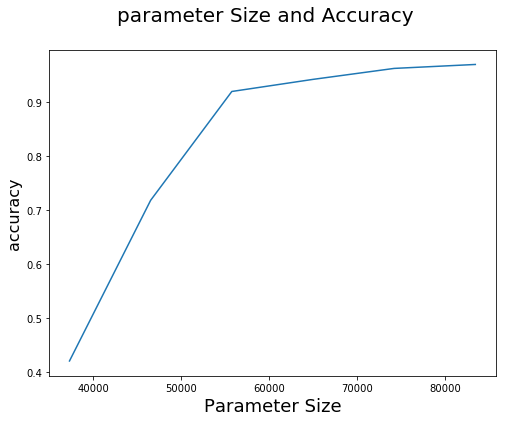

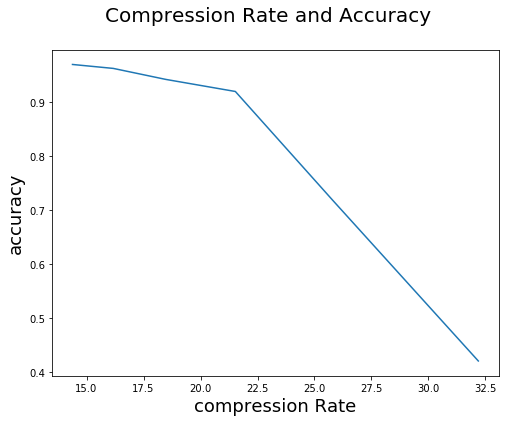

In [14]:
def plot_findings(results,save=False):
    fig = plt.figure()
    fig.suptitle('parameter Size and Accuracy', fontsize=20)
    plt.plot([r['nparams_student'] for r in results] , [r['accuracy_student'] for r in results])
    plt.xlabel('Parameter Size', fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
    if save: 
        fig.savefig('plots/parameterSize_Accuracy.png')
    
    plt.show()
    
    fig = plt.figure()
    fig.suptitle('Compression Rate and Accuracy', fontsize=20)
    plt.plot([r['compressionRate'] for r in results] , [r['accuracy_student'] for r in results])
    plt.xlabel('compression Rate', fontsize=18)
    plt.ylabel('accuracy', fontsize=18)
    
    if save: 
        fig.savefig('plots/CompressionRate_Accuracy.png')
    plt.show()


plot_findings(results,save=True)


### Conclusion 
- Achieved 16.2x compression keeping accuracy at 0.96